In [3]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
# 准备数据集
from utils import *
from collections import Counter

data_csv = pd.read_csv('../csv/dataset.csv')
data_ramdom = data_csv.sample(frac=1, random_state=1).reset_index(drop=True)
data_csv.shape


(13475, 9)

In [5]:
data_1 = data_ramdom[: 8085]
data_2 = data_ramdom[8085: 10780]
data_3 = data_ramdom[10780: 13475]
print(data_1.shape, data_2.shape, data_3.shape)
print(Counter(data_1['label']))
print(Counter(data_2['label']))
print(Counter(data_3['label']))

(8085, 9) (2695, 9) (2695, 9)
Counter({'trojan': 2154, 'virus': 2134, 'worm': 2063, 'backdoor': 1734})
Counter({'trojan': 746, 'virus': 742, 'worm': 685, 'backdoor': 522})
Counter({'virus': 724, 'worm': 711, 'trojan': 700, 'backdoor': 560})


In [6]:
data_path_1, labels_1 = path_loader(data_1)
data_path_2, labels_2 = path_loader(data_2)
data_path_3, labels_3 = path_loader(data_3)
print(data_path_1[: 10])

['../data/2019-05-10/1551800232502f8969e4d307ac43a9ee0284e77467d0ededd8513afeaf5c8f84', '../data/2019-05-10/d7a37f9629ef1d51aa33f9a9a44d4ced5957b0a8e3b2743b508e302e96a005a7', '../data/2019-05-10/d36ae25ddcc24e88479480cc09312c2e9cd78cc124442b5e036035f6bbe70d38', '../data/2017-10-20/ba2c1d6bcb7caf4d620eb5bf90253ddf4deac56ca48f20bff962fa8d31753e36', '../data/2019-05-10/710bb2c9d4b005eeb9328b025ae4eacfe3d437dab280abdacc4515a13f8487ce', '../data/2017-10-20/92275aedb172ac9c51acc38c066297f8e2310cacca29d61465dae7d093d410e2', '../data/2019-05-10/98f67e88ff2172f01c0503c288d1011b1be6111213d903edf6935713b05e58b5', '../data/2018-03-14/56db169302030a173071e4e750de4d94f74386c10f5190455701c0dbc21edd0b', '../data/2018-03-14/01a63c6465ba391ca09da4be58d7e126063b45d4198686b8e365d54c69bff6f1', '../data/2018-03-14/6c8fdc3a8e626eb07977854b5949bbfcced05188438085a0354f5405cf481f78']


In [5]:
# 加载数据并进行训练你
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Sequential, metrics
from tensorflow.keras import Input, Model, regularizers
from malconv import get_malconv


batch_size = 128
db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_train = db_train.batch(batch_size).repeat(9)

db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
db_val = db_val.batch(batch_size).repeat(8)

model = get_malconv()
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(db_train,
                    epochs=7,
                    steps_per_epoch=46,
                    validation_data=db_val,
                    validation_steps=7)

Train for 46 steps, validate for 7 steps
Epoch 1/7
46/46 [==============================] - 313s 7s/step - loss: 1.5563 - categorical_accuracy: 0.7345 - val_loss: 0.9455 - val_categorical_accuracy: 0.8996
Epoch 2/7
46/46 [==============================] - 270s 6s/step - loss: 0.6880 - categorical_accuracy: 0.9412 - val_loss: 0.4807 - val_categorical_accuracy: 0.9844
Epoch 3/7
46/46 [==============================] - 285s 6s/step - loss: 0.4174 - categorical_accuracy: 0.9725 - val_loss: 0.3225 - val_categorical_accuracy: 0.9922
Epoch 4/7
46/46 [==============================] - 291s 6s/step - loss: 0.2942 - categorical_accuracy: 0.9847 - val_loss: 0.2383 - val_categorical_accuracy: 0.9944
Epoch 5/7
46/46 [==============================] - 260s 6s/step - loss: 0.2220 - categorical_accuracy: 0.9914 - val_loss: 0.1946 - val_categorical_accuracy: 0.9944
Epoch 6/7
46/46 [==============================] - 256s 6s/step - loss: 0.1755 - categorical_accuracy: 0.9962 - val_loss: 0.1507 - val_cate

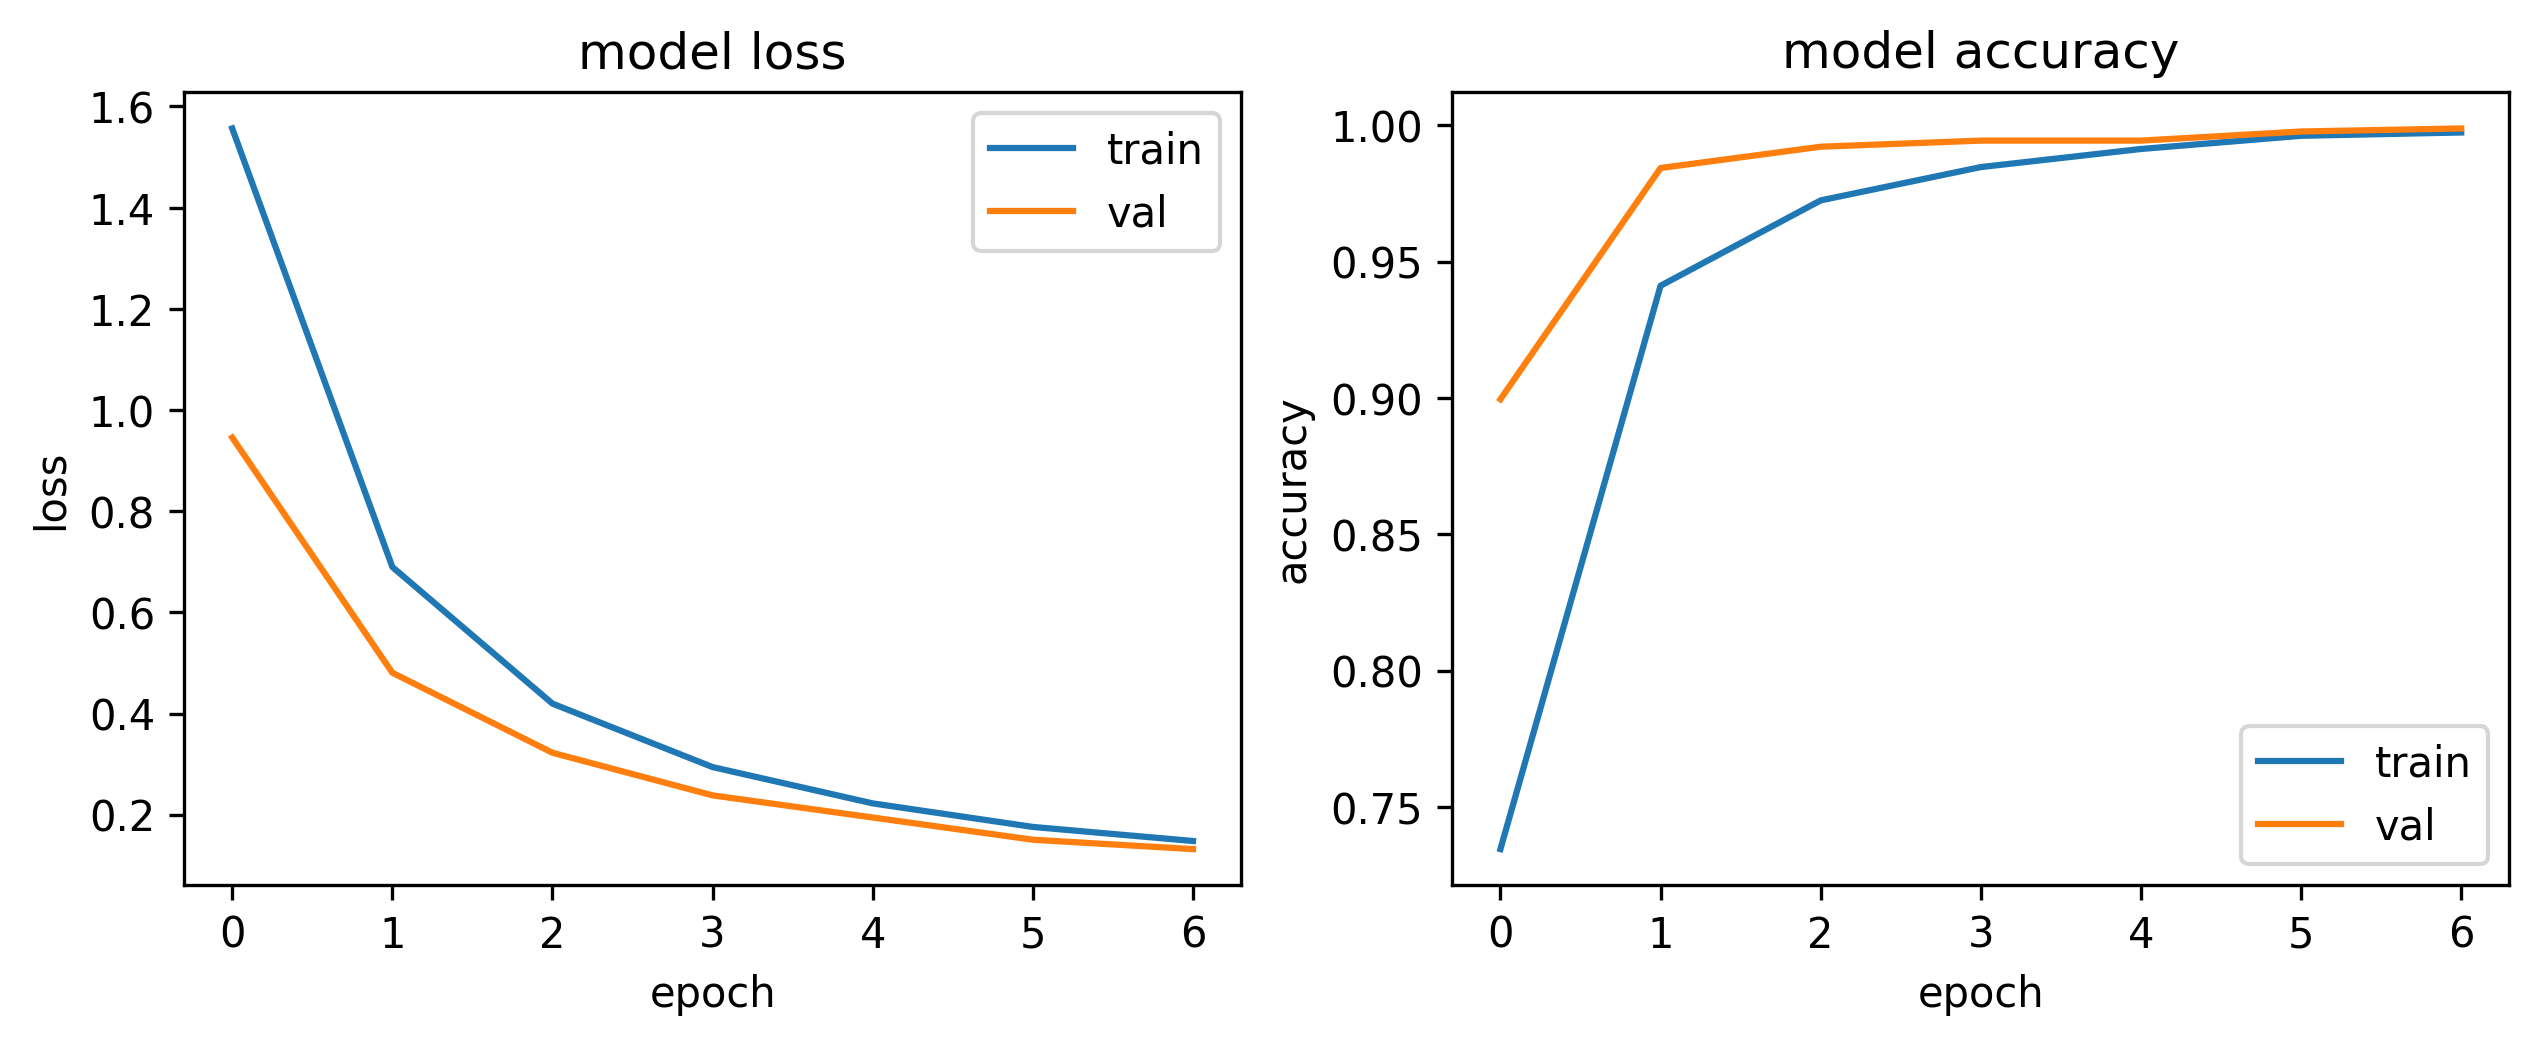

In [7]:
# 绘制loss和acc曲线
def PlotLoss(model_name, history):
    
    p1 = plt.figure(figsize=(10, 3.5),dpi=300)
    ax1 = p1.add_subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="upper right")

    ax2 = p1.add_subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train","val"],loc="lower right")
    plt.savefig("./figures/" + model_name + '.png')
    
PlotLoss('malconv_random', history)

In [8]:
# 保存模型
model.save('./model/malconv_random.h5')

In [7]:
# 测试数据
# 数据1
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('./model/malconv_random.h5')
# 分批预测，防止内存溢出
batch_size = 50
for i in range(0, len(data_path_2), batch_size):
    codes_test_tmp, labels_test_tmp = test_data_loader(data_path_2[i: i + batch_size], labels_2[i: i + batch_size])
    y_pred_tmp = model.predict(codes_test_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(labels_test_tmp, axis=1)
    y_pred = y_pred_tmp if i == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)
    y_true = y_true_tmp if i == 0 else np.concatenate((y_true, y_true_tmp), axis=0)

# codes_test_1, labels_test_1 = test_data_loader(data_path_2, labels_2)
# y_pred = model.predict(codes_test_1)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(labels_test_1, axis=1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names))

100%|██████████| 45/45 [00:01<00:00, 34.57it/s]
              precision    recall  f1-score   support

        worm       0.96      0.98      0.97       746
       virus       0.98      0.98      0.98       742
    backdoor       0.98      0.97      0.98       685
      trojan       0.97      0.97      0.97       522

    accuracy                           0.98      2695
   macro avg       0.97      0.97      0.97      2695
weighted avg       0.98      0.98      0.98      2695



In [8]:
# 数据2
# 分批预测，防止内存溢出
batch_size = 50
for i in range(0, len(data_path_3), batch_size):
    codes_test_tmp, labels_test_tmp = test_data_loader(data_path_3[i: i + batch_size], labels_3[i: i + batch_size])
    y_pred_tmp = model.predict(codes_test_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(labels_test_tmp, axis=1)
    y_pred = y_pred_tmp if i == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)
    y_true = y_true_tmp if i == 0 else np.concatenate((y_true, y_true_tmp), axis=0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names))

100%|██████████| 45/45 [00:05<00:00,  8.21it/s]
              precision    recall  f1-score   support

        worm       0.95      0.98      0.97       700
       virus       0.97      0.97      0.97       724
    backdoor       0.98      0.96      0.97       711
      trojan       0.98      0.97      0.98       560

    accuracy                           0.97      2695
   macro avg       0.97      0.97      0.97      2695
weighted avg       0.97      0.97      0.97      2695



In [9]:
# 使用训练数据进行测试
from sklearn.metrics import classification_report
from tensorflow import keras
model = keras.models.load_model('./model/malconv_random.h5')

# 分批预测，防止内存溢出
batch_size = 50
for i in range(0, len(data_path_1), batch_size):
    codes_train_tmp, labels_train_tmp = test_data_loader(data_path_1[i: i + batch_size], labels_1[i: i + batch_size])
    y_pred_tmp = model.predict(codes_train_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_true_tmp = np.argmax(labels_train_tmp, axis=1)
    y_pred = y_pred_tmp if i == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)
    y_true = y_true_tmp if i == 0 else np.concatenate((y_true, y_true_tmp), axis=0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(y_true, y_pred, target_names=target_names))

100%|██████████| 35/35 [00:02<00:00, 11.77it/s]
              precision    recall  f1-score   support

        worm       1.00      1.00      1.00      2154
       virus       1.00      1.00      1.00      2134
    backdoor       1.00      1.00      1.00      2063
      trojan       1.00      1.00      1.00      1734

    accuracy                           1.00      8085
   macro avg       1.00      1.00      1.00      8085
weighted avg       1.00      1.00      1.00      8085

